# 03 - Interactive Viz

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Please read the notebook from [this URL](http://nbviewer.jupyter.org/github/nunomota/ada2017-hw/blob/master/Homework_03/Homework_03.ipynb).

### Content:
* [Task 1](#t1)
* [Task 2](#t2)
* [Task 3](#t3)
* [Task 4](#t4)

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import json
import folium
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Constants definition

In [2]:
DATA_PATH = './data/'
TOPOJSON_PATH = './topojson/'
EUROSTAT_FILE = 'lfsq_urgaed_sheets.xls'
AMSTAT_FILE = '2_1 Tasso di disoccupazione.xlsx'
ORIGIN_AGE_FILE = '1_1 Disoccupati e persone in cerca d_impiego secondo criteri vari.xlsx'
COUNTRY_LATLONG_FILE = 'countries_latlong.csv'
CANTON_LATLONG_FILE = 'cantons_latlong.csv'
COORDINATE_EUROPE = [54.5260, 15.2551]
COORDINATE_SWITZERLAND = [46.8182, 8.2275]

# Task 1 <a name="t1">

From the eurostat website we found a dataset that includes the European unemployment rates, at a recent date. We made sure that the chosen dataset included the rates for Switzerland as well - since we would like to compare Switzerland's rate to other countries'. From all the datasets containing information about Switzerland, we chose the one with quarterly unemployment rates - more data granularity means we can cherry-pick information from separate years in a continuous fation.

When downloading the dataset we opted to include both the *ID* and the *name* for each country. When comparing the dataset and the TopoJSON file, we noticed some countries didn't match exactly on either one of these fields. This way, by using both *ID* and *name*. we can verify that all the countries are matched accurately.

#### 1.1 Read European data
We first read the `.xls` file containing the unemployment rates per country:

In [3]:
# Read Europe unemployment data
def read_europe_df(sheet):
    """Reads xls file containing European data, and fixes country IDs to match
    TopoJSON file.
    """
    # Read xls file
    df = pd.read_excel('{dp}{f}'.format(dp=DATA_PATH, f=EUROSTAT_FILE),
        sheetname=sheet, skiprows=[12,13,14,15,16,17], header=10, na_values=':')

    # Rename country IDs and names columns
    df.rename(columns={'GEO': 'id', 'GEO(L)/TIME': 'name'}, inplace=True)

    # We need to replace the IDs for UK and Greece so that they match TopoJSON IDs
    return df.replace('UK', 'GB').replace('EL', 'GR')

europe_df = read_europe_df('Data5')

The following is a sample of our dataframe. It includes the quaterly unemployment rates until the second quarter of 2017.

In [4]:
europe_df.head()

,id,name,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2
0,BE,Belgium,8.8,8.4,8.2,8.7,8.3,7.9,7.9,7.2,7.7,7.0
1,BG,Bulgaria,10.6,9.9,8.3,7.9,8.6,8.1,7.0,6.7,6.9,6.3
2,CZ,Czech Republic,6.0,4.9,4.8,4.5,4.4,3.9,4.0,3.6,3.5,3.0
3,DK,Denmark,6.6,6.0,6.2,5.8,6.3,6.0,6.3,6.1,6.5,5.5
4,DE,Germany (until 1990 former territory of the FRG),5.0,4.7,4.4,4.5,4.5,4.2,4.0,3.8,4.1,3.8


#### 1.2 Obtain recent unemployment rate

We need to decide which information we consider interesting. Althought we may be interested in the most recent data, considering only the most recent quarter - or month - can lead to conclussions that are only valid for that specific period of time. This can be caused by seasonal trends on unemployment, that represent drastic changes to our values at a certain time of the year.

Taking the above into consideration, we averaged the rates for the 4 last quarters:
* 2016, Quarter 3
* 2016, Quarter 4
* 2017, Quarter 1
* 2017, Quarter 2

This way we make sure we fulfill our requirements without conceding too much to seasonal trends.

In [5]:
europe_df['recent'] = europe_df[['2016Q3', '2016Q4', '2017Q1', '2017Q2']].mean(axis=1)
recent_europe_df = europe_df[['id', 'recent']]
recent_europe_df.head()

,id,recent
0,BE,7.450
1,BG,6.725
2,CZ,3.525
3,DK,6.100
4,DE,3.925


#### 1.3 Remove countries from TopoJSON file

We now read and modify the topoJSON file for Europe. We remove all the countries that we do not have information about, to avoid plotting them later on the map.

In [6]:
# Load topojson file for Europe
europe_topo_path = r'{tp}europe.topojson.json'.format(tp=TOPOJSON_PATH)
geo_json = json.load(open(europe_topo_path))

# We keep only the countries we have information of
geo_countries = []
for c in geo_json['objects']['europe']['geometries']:
    if c['id'] in list(europe_df['id']):
        geo_countries.append(c)

# We substitute the list of countries
geo_json['objects']['europe']['geometries'] = geo_countries
geo_data = json.dumps(geo_json)

#### 1.4 Create markers (for the map)

This code cell generates a customized DivIcon that we will use as a Marker in our maps. This customized marker will allow us to easily identify the class that each country has been assigned to.

In [7]:
DEFAULT_FONT_SIZE = 24
DEFAULT_IMG_WIDTH = 64
DEFAULT_IMG_HEIGHT = 64
DEFAULT_TEXT_OFFSET = 8
DEFAULT_FONT_COLOR = 'white'
DEFAULT_BG_COLOR = 'black'
DEFAULT_BG_ALPHA = 0.6
DEFAULT_BG_RADIUS_COMPENSATION = DEFAULT_IMG_WIDTH/20
DEFAULT_PALETTE_ICON = 'https://i.imgur.com/HJLCoHt.png'

def generate_custom_icon(percentage):
    """Returns a fully customized DivIcon that can be used
    as a Marker - in folium.
    """
    return DivIcon(
        icon_size=(DEFAULT_IMG_WIDTH, DEFAULT_IMG_HEIGHT),
        icon_anchor=(DEFAULT_IMG_WIDTH/2, DEFAULT_IMG_HEIGHT/2),
        html=generate_custom_icon_html(percentage)
    )
    
def generate_custom_icon_html(percentage):
    """Returns an inlined HTML string representing the
    customized icon, along with a centered percentage.
    """
    html_string = (
        '<div>'
            '<svg width="{1}" height="{2}">'
                '<defs>'
                    '<pattern id="image-bg" x="0" y="0" height="{2}" width="{1}" patternUnits="userSpaceOnUse">'
                        '<image width="{1}" height="{2}" xlink:href="{4}"></image>'
                    '</pattern>'
                '</defs>'
                '<circle cx="{5}" cy="{6}" r="{11}" fill="{9}" fill-opacity="{10}"/>'
                '<circle cx="{5}" cy="{6}" r="{5}" fill="url(#image-bg)"/>'
                '<text x="{5}" y="{7}" font-size="{0}" text-anchor="middle" fill="{3}">{8}%</text>'
            '</svg>'
        '</div>'
    )
    
    return html_string.format(
        DEFAULT_FONT_SIZE,
        DEFAULT_IMG_WIDTH, 
        DEFAULT_IMG_HEIGHT,   
        DEFAULT_FONT_COLOR,
        DEFAULT_PALETTE_ICON,
        DEFAULT_IMG_WIDTH/2,
        DEFAULT_IMG_HEIGHT/2,
        DEFAULT_IMG_HEIGHT/2 + DEFAULT_TEXT_OFFSET,
        round(percentage),
        DEFAULT_BG_COLOR,
        DEFAULT_BG_ALPHA,
        DEFAULT_IMG_WIDTH/2 - DEFAULT_BG_RADIUS_COMPENSATION
    )

We downloaded a CSV file containing the *Lat / Long* coordinates for every country, which we will use to place country-specific information, like the Markers, directly on the map.

In [8]:
# Read LatLong coordinates into a dataframe
country_latlong_df = pd.read_csv('{dp}{f}'.format(dp=DATA_PATH, f=COUNTRY_LATLONG_FILE))
country_latlong_df.columns = country_latlong_df.columns.map(lambda x: x.strip())

# Merge the LatLong coordinates into the already existing dataframe
recent_europe_df = recent_europe_df.merge(country_latlong_df, how='inner', left_on='id', right_on='country').drop(['country'], axis=1)

#### 1.5 Create map

Lastly, we create the map for Europe.

The color palette picking was pretty straight forward. We wanted to achieve two things: (1) squenciality; and (2) clarity. To achieve (1), creating a palette from a color gradient would be the best option. To satisfy (2) we had to narrow down our options a bit and opted for a gradient that would work with only the Red channel of the RGB spectrum. Any other channel would give a pretty clear idea of difference in *intensity* or *value* but the Red channel is already intuitively interpreted as *danger*. So the more intense the color red gets, the higher the percentages of unemployment, the worst the situation.

As for the 6 intervals, we wanted to give a high-enough color range so the user could clearly see differences with naked eyes, but not high enough so that he could confuse some of the colors. With this in mind, we eventually settled for the number 6 as being a good balance between the two.

In [9]:
from folium.plugins import MarkerCluster
from folium.features import DivIcon

# Create a new map
map_europe = folium.Map(COORDINATE_EUROPE, tiles=None, zoom_start=3)

# Add tile layers
folium.TileLayer('cartodbpositron').add_to(map_europe)

# Plot total unemployment
map_europe.choropleth(geo_data=json.loads(geo_data), name='Total Population',
    data=recent_europe_df, columns=['id', 'recent'], key_on='feature.id', fill_opacity=1,
    fill_color='YlOrRd', topojson='objects.europe')

# Marker cluster / Custom html icon
marker_cluster = MarkerCluster(name='[Markers] Total Population').add_to(map_europe)
for index, row in recent_europe_df.iterrows():
    lat = row['latitude']
    long = row['longitude']
    percent = row['recent']
    country_name = row['name']
    folium.Marker([lat, long], icon=generate_custom_icon(percent), popup=country_name).add_to(marker_cluster)

# Add LayerControl
folium.LayerControl(collapsed=False).add_to(map_europe)

You can now visualize and interact with the map!

* You can zoom in to show the markers with the information for each country. You can also click on the clusters of markers to zoom in directly.

* To see the country's name you can click on its marker.

* The markers make it easier to see which class each country is assigned to.

In [10]:
map_europe

The unemployment rate in Switzerland is one of the lowest in Europe, as can be verified from the assigned color - lightest in the scale.

Looking directly at numbers, Swiss unemployment rate is 5% and only Iceland, Malta, the Czech Republic, Germany and Norway have a lower rate (3%-4%).

In general, the countries in southern Europe have higher unemployment rates, especially in the cases of Macedonia, Greece and Spain.

# Task 2 <a name="t2">
In the amstat website we found a dataset including the unemployment rates in Switzerland for the last 12 months.

#### 2.1 Read data
We read the unemployment rates for the last 12 months. For this case we created a function that returns a dataframe containing the average (*Totale*) for those months, as well as a column with the IDs for each canton. 

Therefore, the variables we read from this dataset for each canton are:
* Unemployment rate
* Unemployed
* Looking for job
* Not unemployed looking for job

In [11]:
# Load topojson file for Europe
swiss_topo_path = r'{tp}ch-cantons.topojson.json'.format(tp=TOPOJSON_PATH)
geo_json = json.load(open(swiss_topo_path))

In [12]:
def get_clean_swiss_df(file, headers, dictionary, ids):
    """Reads xls file containing Swiss data.
    Translates variable names to English and gets the 'Total' column
    for each variable.
    """
    # Read xls file containing Swiss unemployment data
    df = pd.read_excel('{dp}{f}'.format(dp=DATA_PATH, f=file), header=headers)
    df.drop(('Metriche', 'mese'), axis=1, inplace=True)

    # We will create a dataframe in English with the variables we need
    clean_df = pd.DataFrame()

    # For each variable, we get the 'Total' column
    variables_list = df.columns.get_level_values(0).unique()
    for v in variables_list:
        clean_df[italian_english_variables[v]] = df[(v, 'Totale')]

    clean_df.drop('Totale', inplace=True)

    # Add 'id' column to the dataframe
    clean_df['id'] = ids
    
    return clean_df

The IDs were directly taken from the TopoJSON file, since we manually verified that the cantons are in the same order in both the TopoJSON file and the data files we obtained from amstat. We translate the names of the variables to English using a manually defined dictionary.

In [13]:
# Manually define dictionary with translations to English
italian_english_variables = {
    "Tasso di disoccupazione": 'Unemployment rate',
    "Disoccupati registrati": 'Unemployed',
    "Persone in cerca d'impiego": 'Looking for job',
    "Persone in cerca d'impiego non disoccupate": 'Not unemployed looking for job',
    'stranieri': 'Foreigners',
    'svizzeri': 'Swiss'
}

In [14]:
# Get the 'id' for each canton directly from the JSON file
cantons_id = []
for c in geo_json['objects']['cantons']['geometries']:
    cantons_id.append(c['id'])

switzerland_df = get_clean_swiss_df(file=AMSTAT_FILE, headers=[2,3],
    dictionary=italian_english_variables, ids=cantons_id)

The following is a sample of the resulting dataframe:

In [15]:
switzerland_df.set_index('id').head()

,Unemployment rate,Unemployed,Looking for job,Not unemployed looking for job
id,,,,
ZH,3.6,355658,440479,84821
BE,2.7,181433,238627,57194
LU,1.9,51925,87769,35844
UR,1.1,2430,4314,1884
SZ,1.8,18765,28363,9598


#### 2.2 Add data on people looking for a job
The Swiss Confederation defines the *Unemployment rate* as the number of unemployed registered, divided by the size of the active population, multiplied by 100 ([reference](https://www.amstat.ch/v2/definition.jsp?lang=fr)).

We will now include the *Looking for job rate*. It will be computed as the size of the respective population divided by the size of the active population, multiplied by 100. We will then plot both rates to see if there are differences.

We do not compute and plot the *Not unemployed looking for job* rate (i.e. people who already have a job and are looking for a new one), since it is equal to substracting the *Unemployment rate* from the *Looking for job rate*.

In [16]:
switzerland_df['Looking for job rate'] = (switzerland_df['Unemployment rate'] *
    switzerland_df['Looking for job'] / switzerland_df['Unemployed'])

switzerland_df.drop(['Unemployed', 'Looking for job',
    'Not unemployed looking for job'], axis=1).set_index('id').head()

,Unemployment rate,Looking for job rate
id,,
ZH,3.6,4.458565
BE,2.7,3.551134
LU,1.9,3.211576
UR,1.1,1.952840
SZ,1.8,2.720671


#### 2.3 Create map <a name="cm">

We now create the map showing the unemployment rate in Swiss cantons. We use the same color range and intervals as for the Europe map.

In [17]:
# Read each canton's lat long coordinates
canton_latlong_df = pd.read_csv('{dp}{f}'.format(dp=DATA_PATH, f=CANTON_LATLONG_FILE))

# Merge the LatLong coordinates into the already existing dataframe
switzerland_df = switzerland_df.merge(canton_latlong_df, how='inner', left_on='id', right_on='id')

26


In [18]:
switzerland_df.head()

,Unemployment rate,Unemployed,Looking for job,Not unemployed looking for job,id,Looking for job rate,latitude,longitude
0,3.6,355658,440479,84821,ZH,4.458565,47.3769,8.5417
1,2.7,181433,238627,57194,BE,3.551134,46.9480,7.4474
2,1.9,51925,87769,35844,LU,3.211576,47.0502,8.3093
3,1.1,2430,4314,1884,UR,1.952840,46.7739,8.6025
4,1.8,18765,28363,9598,SZ,2.720671,47.0207,8.6530


In [19]:
# Create a new map
map_swiss = folium.Map(COORDINATE_SWITZERLAND,
    tiles='cartodbpositron', zoom_start=8)

# Plot people looking for a job
map_swiss.choropleth(geo_data=geo_json, name='Looking for job',
    data=switzerland_df, columns=['id', 'Looking for job rate'], key_on='feature.id', fill_opacity=1,
    fill_color='YlOrRd', topojson='objects.cantons')

# Marker cluster / Custom html icon
marker_cluster = MarkerCluster(name='[Markers] Looking for Job').add_to(map_swiss)
for index, row in switzerland_df.iterrows():
    lat = row['latitude']
    long = row['longitude']
    canton_id = row['id']
    percent = row['Looking for job rate']
    folium.Marker([lat, long], icon=generate_custom_icon(percent), popup=canton_id).add_to(marker_cluster)

# Plot people that are unemployed
map_swiss.choropleth(geo_data=geo_json, name='Unemployed',
    data=switzerland_df, columns=['id', 'Unemployment rate'], key_on='feature.id', fill_opacity=1,
    fill_color='YlOrRd', topojson='objects.cantons')

# Marker cluster / Custom html icon
marker_cluster = MarkerCluster(name='[Markers] Unemployed').add_to(map_swiss)
for index, row in switzerland_df.iterrows():
    lat = row['latitude']
    long = row['longitude']
    canton_id = row['id']
    percent = row['Unemployment rate']
    folium.Marker([lat, long], icon=generate_custom_icon(percent), popup=canton_id).add_to(marker_cluster)

# Add LayerControl
folium.LayerControl(collapsed=False).add_to(map_swiss)

You can now interact with the map!
* You can compare the unemployment rate and the rate of people looking for a job by checking one or the other in the box at the right.
* Notice the two color scales on top: the one in the left corresponds to people looking for a job, the one in the right corresponds to only those unemployed.
* Since the color scales for both rates are different, from this figure we can't directly compare the two rates to each other. However, this allows us to compare how the cantons are doing regarding both rates.
* You can activate or desactivate the markers for each layer as well. Make sure you activated the correct Map-Marker pair of layers!

In [20]:
map_swiss

# Task 3 <a name="t3">
We use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

#### 3.1 Read data
We now define a function to compute the average unemployment data, for a dataframe containing the data for several months.

In [21]:
def get_average_swiss_df(df, dictionary, ids):
    """Reads an xls file containing Swiss data for several months but
    without a 'Total' column. Computes for each variable the yearly average
    from the monthly values.
    """
    # We will create a dataframe in English with the variables we need
    clean_df = pd.DataFrame()

    # For each variable, we get an average column
    variables_list = df.columns.get_level_values(0).unique()
    for v in variables_list:
        clean_df[italian_english_variables[v]] = df[v].mean(axis=1)
    
    # Drop 'Totale' row
    clean_df.drop('Totale', inplace=True)
    
    # Add 'id' column to the dataframe
    clean_df['id'] = ids
    
    # Drop variables we will not use
    clean_df.drop(italian_english_variables["Persone in cerca d'impiego"],
        axis=1, inplace=True)
    clean_df.drop(italian_english_variables["Persone in cerca d'impiego non disoccupate"],
        axis=1, inplace=True)
    
    return clean_df

We read the file containing the unemployment data for both *foreigners* and *Swiss*. Then, we create a dictionary containing two dataframes - one for each category mentioned before. We then apply the function to each dataframe to obtain an average per month.

Also, to complement the information on the map we will create, we merge this dataframe with one containing *Lat / Long* coordinates for each of the cantons.

In [22]:
# Read xls file containing unemployment data per origin
origin_df = pd.read_excel('{dp}{f}'.format(dp=DATA_PATH, f="foreign swiss {df}".format(df=AMSTAT_FILE)),
    header=[2,3,4])
origin_df.drop(('Nazionalità', 'Metriche', 'mese'), axis=1, inplace=True)

# We create a dictionary of dataframes
origin_df_dict = {}

# For each origin we get the corresponding dataframe
origins_list = origin_df.columns.get_level_values(0).unique()
for o in origins_list[:2]:
    origin_df_dict[italian_english_variables[o]] = get_average_swiss_df(
        origin_df[o],
        italian_english_variables, cantons_id
    ).merge(
        canton_latlong_df,
        how='inner',
        left_on='id',
        right_on='id'
    )

Samples of the dataframes:

In [23]:
origin_df_dict['Swiss'].set_index('id').head()

,Unemployment rate,Unemployed,latitude,longitude
id,,,,
ZH,2.716667,16108.833333,47.3769,8.5417
BE,1.975000,9375.833333,46.9480,7.4474
LU,1.366667,2487.750000,47.0502,8.3093
UR,0.558333,92.166667,46.7739,8.6025
SZ,1.241667,861.500000,47.0207,8.6530


In [24]:
origin_df_dict['Foreigners'].set_index('id').head()

,Unemployment rate,Unemployed,latitude,longitude
id,,,,
ZH,5.925000,13529.333333,47.3769,8.5417
BE,6.475000,5743.583333,46.9480,7.4474
LU,4.491667,1839.333333,47.0502,8.3093
UR,4.350000,110.333333,46.7739,8.6025
SZ,3.900000,702.250000,47.0207,8.6530


We also want to obtain the difference in unemployment rate for foreigners and Swiss, for each canton:

In [25]:
difference_origin_df = pd.DataFrame()
difference_origin_df['id'] = origin_df_dict['Foreigners']['id']
difference_origin_df['diff'] = (origin_df_dict['Foreigners']['Unemployment rate'] - 
    origin_df_dict['Swiss']['Unemployment rate'])

#### 3.2 Create map to compare Swiss and foreign unemployment rates

In [26]:
# Create a new map
map_swiss_origin = folium.Map(COORDINATE_SWITZERLAND,
    tiles='cartodbpositron', zoom_start=8)

# Plot difference in unemployment rates
map_swiss_origin.choropleth(geo_data=geo_json, name='Foreign - Swiss',
    data=difference_origin_df, columns=['id', 'diff'], key_on='feature.id', fill_opacity=1,
    fill_color='BuPu', topojson='objects.cantons')

# Plot unemployment rate for Swiss
map_swiss_origin.choropleth(geo_data=geo_json, name='Swiss',
    data=origin_df_dict['Swiss'], columns=['id', 'Unemployment rate'], key_on='feature.id', fill_opacity=1,
    fill_color='YlOrRd', topojson='objects.cantons')

# Marker cluster / Custom html icon
marker_cluster = MarkerCluster(name='[Markers] Swiss').add_to(map_swiss_origin)
for index, row in origin_df_dict['Swiss'].iterrows():
    lat = row['latitude']
    long = row['longitude']
    canton_id = row['id']
    percent = row['Unemployment rate']
    folium.Marker([lat, long], icon=generate_custom_icon(percent), popup=canton_id).add_to(marker_cluster)

# Plot unemployment rate for Foreigners
map_swiss_origin.choropleth(geo_data=geo_json, name='Foreign',
    data=origin_df_dict['Foreigners'], columns=['id', 'Unemployment rate'], key_on='feature.id', fill_opacity=1,
    fill_color='YlOrRd', topojson='objects.cantons')

# Marker cluster / Custom html icon
marker_cluster = MarkerCluster(name='[Markers] Foreign').add_to(map_swiss_origin)
for index, row in origin_df_dict['Foreigners'].iterrows():
    lat = row['latitude']
    long = row['longitude']
    canton_id = row['id']
    percent = row['Unemployment rate']
    folium.Marker([lat, long], icon=generate_custom_icon(percent), popup=canton_id).add_to(marker_cluster)

# Add LayerControl
folium.LayerControl(collapsed=False).add_to(map_swiss_origin)

You can now interact with the map!
* You can look at the Swiss or Foreigners unemployment rates, or maybe plot the difference in both.
* The rate difference is always positive, because the unemployment rate is always higher for foreigners than for Swiss. It has been represented in a different color scale because it does not represent a *ratio*, but the *difference in ratios*. Cantons with a bigger difference in rates are represented in a darker color.
* You can check the markers fot the Swiss and Foreign unemployment rates. Make sure you activated the correct Map-Marker pair of layers!

In [27]:
map_swiss_origin

It is observed clearly that in most cantons the unemployment rate is higher for foreigners than for Swiss. However, in most cantons in Switzerland there is a relatively low overall unemployment rate, although we can see it is higher in Ticino (TI), Zürich (ZH) and the French speaking part of Switzerland. 

As for the unemployment rate for Swiss people only, it is higher in the West part of Switzerland. Jura (JU) and Neuchâtel (NE) have the highest unemployment rates.

The largest differences in unemployment rates for Swiss and foreigners are found in Jura (JU) and Valais (VS). This difference is smaller in western half of Switzerland.

#### 3.3 Data per origin and age group
Now we refine the analysis by adding the differences between age groups. Since it is nearly impossible to plot so many variables on a map, we made a bar plot instead.

In [28]:
# Read xls file containing unemployment data per age
age_df = pd.read_excel('{dp}{f}'.format(dp=DATA_PATH, f="ages {df}".format(df=AMSTAT_FILE)),
    header=[2,4,5])
age_df.drop(("Classi d'età 15-24, 15-49, 50 anni e più", 'Metriche', 'mese'), axis=1, inplace=True)

# We create a dictionary to map age class with the corresponding age range
age_labels_dic = {'1': '15-24', '2': '15-49', '3': '+50'}

# We create a dictionary of dataframes
age_df_dict = {}

# For each age we get the corresponding dataframe
ages_list = age_df.columns.get_level_values(0).unique()
for o in ages_list[:3]:
    age_df_dict[age_labels_dic[o]] = get_average_swiss_df(age_df[o],
        italian_english_variables, cantons_id)

Samples:

In [29]:
age_df_dict['15-24'].set_index('id').head()

,Unemployment rate,Unemployed
id,,
ZH,3.733333,3434.083333
BE,2.841667,2042.666667
LU,2.241667,701.666667
UR,0.933333,28.333333
SZ,1.408333,163.500000


The methods below are simply use as auxiliary operations to parse/treat our data:

In [30]:
def rename_row_values(df):
    """Creates a new dataframe that contains all the rows'
    values trnaslated to english for better understanding
    and clarity.
    """
    nationality_rename_dic = {
        'stranieri':'foreign',
        'svizzeri':'swiss'
    }
    age_range_rename_dic = {
        '15-24 anni':'15-24',
        '25-49 anni':'25-49',
        '50 anni e più':'50+'
    }
    age_group_rename_dic = {
        '1':'1',
        '2':'2',
        '3':'3',
        'Totale':'Total'
    }
    renamed_df = df
    renamed_df['Nationality'] = renamed_df['Nationality'].apply(lambda x: nationality_rename_dic.get(x, 'all'))
    renamed_df['Age Range'] = renamed_df['Age Range'].apply(lambda x: age_range_rename_dic.get(x, float('NaN')))
    renamed_df['Age Group'] = renamed_df['Age Group'].apply(lambda x: age_group_rename_dic.get(x, 'Total'))
    return renamed_df

def refine_origin_age_df(df):
    """Creates a new dataframe that contains all the columns'
    names translated to english for better understanding
    and clarity.
    """
    refined_df = df
    refined_df.columns = df.columns.droplevel(1)
    refined_df.drop(['mese'], axis=1, inplace=True)
    rename_dic = {
        'Cantone':'Canton',
        'Nazionalità':'Nationality',
        'Classi d\'età 15-24, 15-49, 50 anni e più':'Age Group',
        'Ottobre 2016':'October 2016',
        'Novembre 2016':'November 2016',
        'Dicembre 2016':'December 2016',
        'Gennaio 2017':'January 2017',
        'Febbraio 2017':'February 2017',
        'Marzo 2017':'March 2017',
        'Aprile 2017':'April 2017',
        'Maggio 2017':'May 2017',
        'Giugno 2017':'June 2017',
        'Luglio 2017':'July 2017',
        'Agosto 2017':'August 2017',
        'Settembre 2017':'September 2017'
    }
    refined_df.rename(columns=rename_dic, inplace=True)
    refined_df.columns.values[2] = 'Age Range'
    refined_df = rename_row_values(refined_df)
    return refined_df

In [31]:
# Read Excel file with information on age group and origin
origin_age_df = pd.read_excel('{dp}{f}'.format(dp=DATA_PATH, f=ORIGIN_AGE_FILE), header=[2, 3])

In [32]:
# Format and reindex dataframe
origin_age_df = refine_origin_age_df(origin_age_df)
origin_age_df.set_index(origin_age_df['Age Group'], append=True, inplace=True)
origin_age_df.set_index(origin_age_df['Nationality'], append=True, inplace=True)

# Create a dataframe with an average over all the read months
origin_age_df = origin_age_df.filter(like='20').mean(axis=1, skipna=True).to_frame()

0
       Age Group Nationality              
Zurigo 1         foreign       1085.833333
       2         foreign       9963.333333
       3         foreign       2480.166667
       Total     foreign      13529.333333
       1         swiss         2348.250000
       2         swiss         8980.750000
       3         swiss         4779.833333
       Total     swiss        16108.833333
                 all          29638.166667

You can see below a sample from the created dataframe. It basically contains the size of the population within each category - given by a combination of *age group*, *nationality* and *canton*.

In [ ]:
origin_age_df.head(9)

In [33]:
def get_origin_age_rates(df):
    """Creates a new dataframe with calculated ratios
    according to origin, age group and canton.
    """
    index_value_dic = df.to_dict()[0]
    cantons = df.index.get_level_values(0).unique().tolist()
    cantons.remove('Totale')
    ages = range(1, 4)
    nationalities = ['foreign', 'swiss']
    
    # Create new dict (to be converted to a dataframe)
    rates_dic = {}
    swiss_population = index_value_dic[('Totale', 'Total', 'all')]
    for canton in cantons:
        canton_population = index_value_dic[(canton, 'Total', 'all')]
        for nationality in nationalities:
            nationality_population = index_value_dic[(canton, 'Total', nationality)]
            for age in ages:
                key = (canton, str(age), nationality)
                value = index_value_dic[key]
                rates_dic[key] = value / nationality_population
            rates_dic[(canton, 'Total', nationality)] = nationality_population / canton_population
        rates_dic[(canton, 'Total', 'all')] = canton_population / swiss_population
    
    # Convert filled dict to dataframe
    rates_df = pd.DataFrame.from_dict(rates_dic, orient='index')
    rates_df.index = pd.MultiIndex.from_tuples(rates_df.index)
    rates_df.index.names = ['Canton', 'Age Group', 'Nationality']
    rates_df.columns = ['Rate']
    return rates_df

In [34]:
origin_age_df = get_origin_age_rates(origin_age_df)

Rate
Canton Age Group Nationality          
Zurigo 1         foreign      0.080258
       2         foreign      0.736425
       3         foreign      0.183318
       Total     foreign      0.456483
       1         swiss        0.145774
       2         swiss        0.557505
       3         swiss        0.296721
       Total     swiss        0.543517
                 all          0.202993

As we needed to compare rates (and not exactly population sizes), we generated a new dataframe as seen below:

In [ ]:
origin_age_df.head(9)

**Note:** The values on this dataframe cannot be interpreted randomly, as these rates do not all refer to a rate in the overall Swiss population. You have to pay attention to three different types of ratios:

* (x -> "Total" -> "all") represents the ratio of people in canton *x*
* (x -> "Total" -> y) represents the ratio of people with nationality *y*, within canton *x*
* (x -> y -> z) represents the ration of people within age group *z*, with nationality *y*, within canton *x*

To give a clear example for the canton displayed above, adding the rates for *foreign* - accross age groups 1, 2 and 3 - will yield 1.0 as a result. This, in turn, represents 45,6483% of the population considered for that canton (given by: Zurigo -> Total -> foreign). Lastly, all of Zurigo's population only accounts for 20.2993% of the overall Swiss population (given by: Zurigo -> Total -> all).

We opted to keep all this information to allow us more freedom in case we wanted to calculate rates for different populations or categories.

#### 3.4 Plotting the information
As this is too much information to plot at once, we decided to split it into it's most interesting components and plot them separately:

1. Unemplyoment contribution, by canton (the percentage of unemployment, in the swiss population, caused by each canton)
2. Ratio of unemplyment of "foreign versus swiss" people, by canton
3. Ratio of unemplyment accross age groups, by canton

You can use this order as a reference while browsing through the plots (same order is kept).

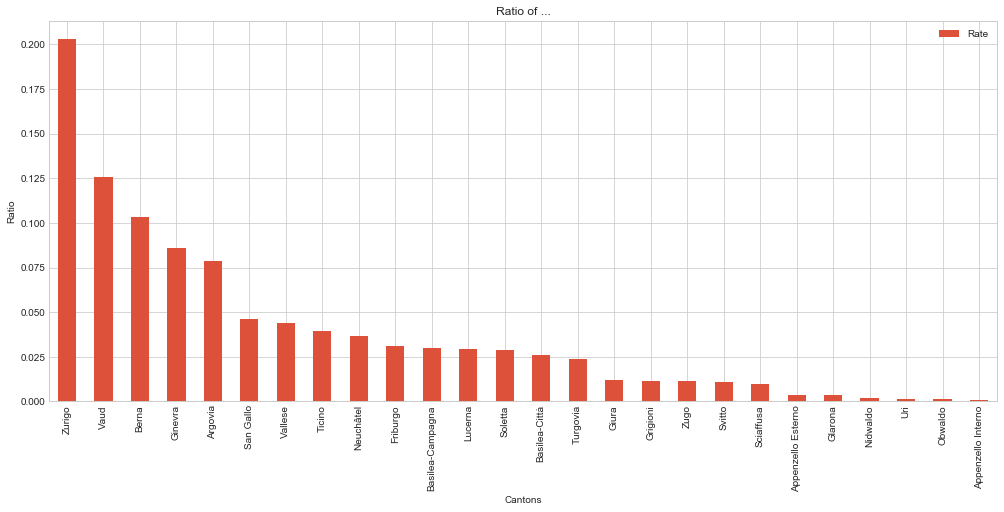

In [35]:
by_canton_df = origin_age_df.reset_index()

# Slim down the Dataframe by selecting the needed rows
by_canton_df = by_canton_df.loc[ (by_canton_df['Age Group'] == 'Total') & (by_canton_df['Nationality'] == 'all' ) ]

# Keep the useful cols
by_canton_df.drop(['Age Group', 'Nationality'], axis=1, inplace=True)

# Index by canton name
by_canton_df.set_index('Canton', drop=True, inplace=True)

# Order by the rate
by_canton_df.sort_values(by='Rate', ascending=False, inplace=True)


# Show the plot
color = cm.inferno_r(np.linspace(.4,.8, 30))
by_canton_df.plot.bar(figsize=(17, 7), color=color)

plt.title('Ratio of unemplyment by canton')
plt.ylabel("Ratio")
plt.xlabel('Cantons')
plt.show()

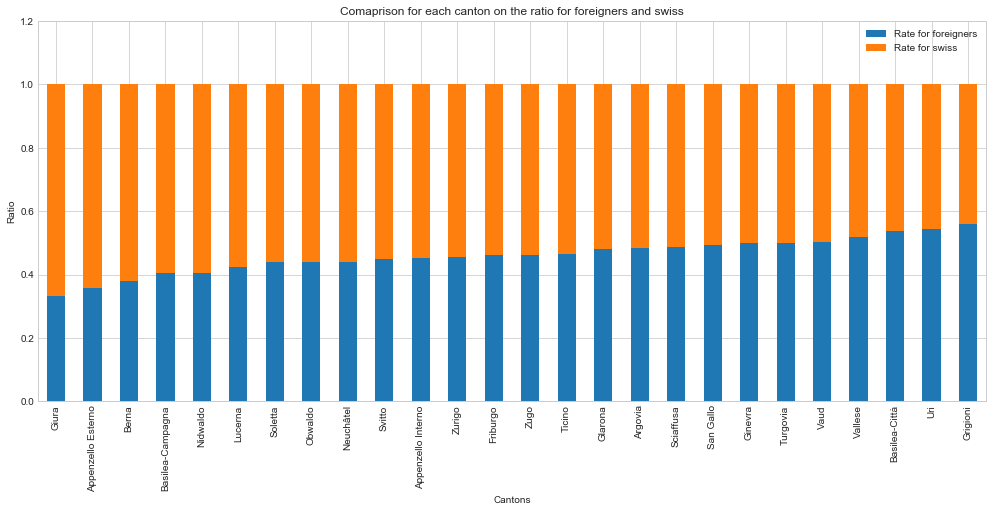

In [36]:
by_nationality_df = origin_age_df.reset_index()

# Get two dataframes for the labels (foreigner, swiss) data in order to merge them later as columns
foreign_df = by_nationality_df.loc[ (by_nationality_df['Age Group'] == 'Total') & (by_nationality_df['Nationality'] == 'foreign' )]
swiss_df = by_nationality_df.loc[ (by_nationality_df['Age Group'] == 'Total') & (by_nationality_df['Nationality'] == 'swiss' )]

by_nationality_df = pd.merge(foreign_df, swiss_df, on=['Canton'])


# Keep the useful cols
by_nationality_df.drop(['Age Group_x', 'Age Group_y', 'Nationality_x', 'Nationality_y',], axis=1, inplace=True)

# Rename
by_nationality_df = by_nationality_df.rename(columns={'Rate_x': 'Rate for foreigners',
                                                      'Rate_y': 'Rate for swiss'})

# Index by canton name
by_nationality_df.set_index('Canton', drop=True, inplace=True)

# Order by the rate
by_nationality_df.sort_values(by='Rate for swiss', ascending=False, inplace=True)


# Show the plot
by_nationality_df.plot.bar(figsize=(17, 7), stacked=True)

plt.title('Comaprison for each canton on the ratio for foreigners and swiss')
plt.ylabel("Ratio")
plt.xlabel('Cantons')
plt.ylim(0,1.2)
plt.show()

In [37]:
def clean_up_by_age_df(input_df):
    df_1 = input_df.loc[ input_df["Age Group"] == "1" ]
    df_2 = input_df.loc[ input_df["Age Group"] == "2" ]
    df_3 = input_df.loc[ input_df["Age Group"] == "3" ]

    df = pd.merge(pd.merge(df_1, df_2, on=['Canton']), df_3, on=['Canton'])

    # Keep the useful cols
    df.drop(['Age Group_x', 'Age Group_y', 'Nationality_x', 'Nationality_y', 'Age Group', 'Nationality'], axis=1, inplace=True)

    # Rename
    df = df.rename(columns={'Rate_x': 'Rate age 1', 'Rate_y': 'Rate age 2', 'Rate': 'Rate age 3'})
    
    # Index by canton name
    df.set_index('Canton', drop=True, inplace=True)
    
    return df

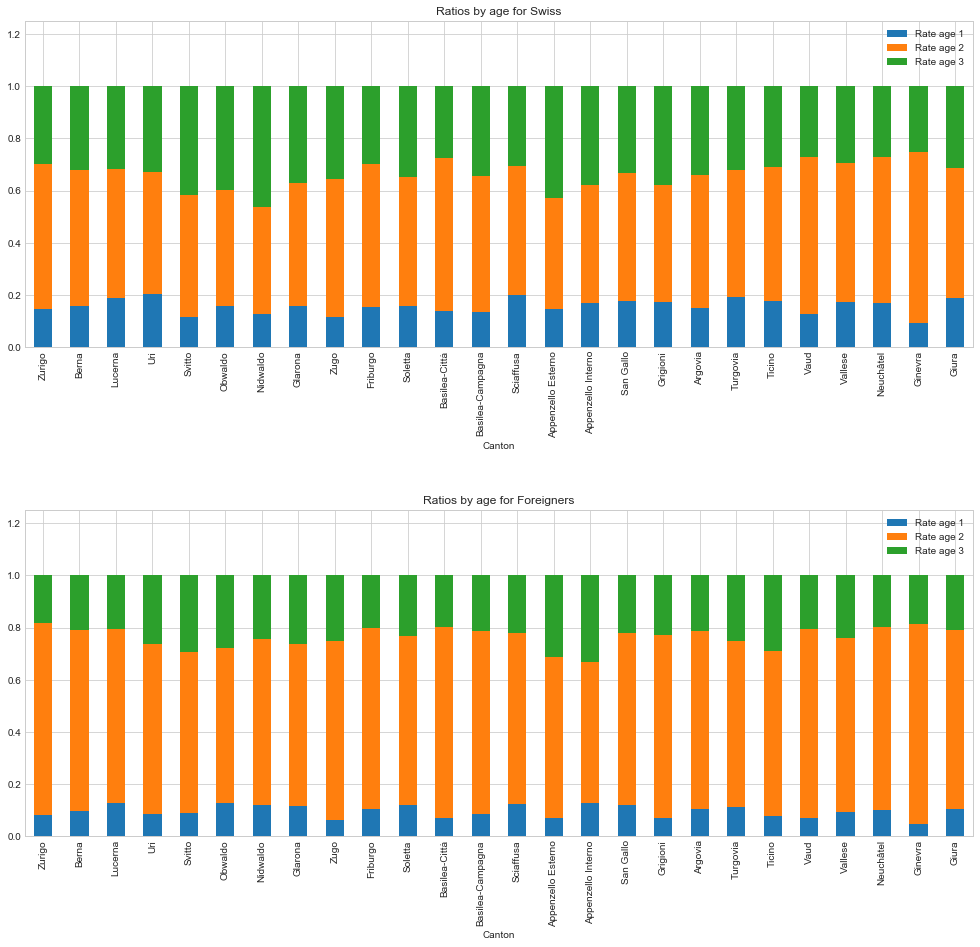

In [38]:
by_age_df = origin_age_df.reset_index()

by_age_df

# Get two dataframes for the labels (foreigner, swiss) data in order to merge them later as columns
foreign_df = by_age_df.loc[ (by_age_df['Age Group'] != 'Total') & (by_age_df['Nationality'] == 'foreign' )]
swiss_df = by_age_df.loc[ (by_age_df['Age Group'] != 'Total') & (by_age_df['Nationality'] == 'swiss' )]

foreign_df = clean_up_by_age_df(foreign_df)
swiss_df = clean_up_by_age_df(swiss_df)

# Show the plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(17, 15))
fig.subplots_adjust(hspace=.5)

ax_swiss = swiss_df.plot.bar( stacked=True, ax=axes.flat[0], title='Ratios by age for Swiss', ylim=(0, 1.25))
foreign_df.plot.bar( stacked=True, ax=axes.flat[1], title='Ratios by age for Foreigners', ylim=(0, 1.25))

plt.show()

# Task 4 <a name="t4">

We use the maps we have built for Switzerland to give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben.

For that we will use the unemployment rates for Swiss people only. Since we saw that in most cases the unemployment was higher for foreigners, we can consider that the unemployment in an area might depend on the number of foreigners.

From what we saw [previously](#cm), we can set an unemployment rate of 4.2 as the limit between cantons in both sides of the Röstigraben.

In [39]:
# Used to compute harmonic mean
from scipy import stats

In [40]:
LIMIT_ROSTIGRABEN = 4.2

switzerland_df['class'] = (switzerland_df['Unemployment rate'] < LIMIT_ROSTIGRABEN)
switzerland_df['labels'] = switzerland_df['Unemployment rate'].apply(
    lambda x: 'German' if x < LIMIT_ROSTIGRABEN else 'French')

In [41]:
switzerland_df.head()

,Unemployment rate,Unemployed,Looking for job,Not unemployed looking for job,id,Looking for job rate,latitude,longitude,class,labels
0,3.6,355658,440479,84821,ZH,4.458565,47.3769,8.5417,True,German
1,2.7,181433,238627,57194,BE,3.551134,46.9480,7.4474,True,German
2,1.9,51925,87769,35844,LU,3.211576,47.0502,8.3093,True,German
3,1.1,2430,4314,1884,UR,1.952840,46.7739,8.6025,True,German
4,1.8,18765,28363,9598,SZ,2.720671,47.0207,8.6530,True,German


In [42]:
# Create a new map
map_swiss_rosti = folium.Map(COORDINATE_SWITZERLAND,
    tiles='cartodbpositron', zoom_start=8)

# Create scale
minimum = min(switzerland_df['Unemployment rate'])
maximum = max(switzerland_df['Unemployment rate'])
rosti_scale = list(np.linspace(minimum, maximum, 2))

# Plot unemployment rate for Swiss
map_swiss_rosti.choropleth(geo_data=geo_json, name='Estimated Röstigraben',
    data=switzerland_df, columns=['id', 'class'], key_on='feature.id', fill_opacity=1,
    fill_color='Accent', topojson='objects.cantons', threshold_scale=rosti_scale)

marker_cluster = MarkerCluster(name='[Markers] Cantons').add_to(map_swiss_rosti)
for index, row in switzerland_df.iterrows():
    lat = row['latitude']
    long = row['longitude']
    canton_id = row['id']
    folium.Marker([lat, long], popup=canton_id).add_to(marker_cluster)

map_swiss_rosti

To verify if their unemployment rates are very different or not, we compute the [harmonic mean](https://www.wikipedia.com/en/Harmonic_mean) for the two  groups of cantons that we obtained.

In [43]:
swiss_mean = switzerland_df[['labels', 'Unemployment rate']].groupby('labels').agg(stats.hmean)
swiss_std = switzerland_df[['labels', 'Unemployment rate']].groupby('labels').agg(np.std)

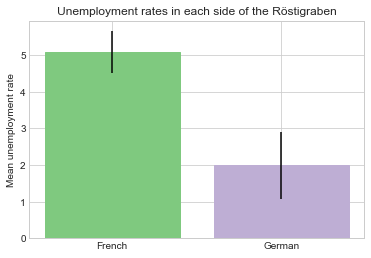

In [44]:
ind = np.arange(2)
barlist = plt.bar(ind, swiss_mean['Unemployment rate'], color='#d62728', yerr=swiss_std['Unemployment rate'])
barlist[0].set_color('#7fc97f')
barlist[1].set_color('#beaed4')

plt.ylabel('Mean unemployment rate')
plt.title('Unemployment rates in each side of the Röstigraben')
plt.xticks(ind, swiss_mean.index)

plt.show()

We can see that there is indeed a considerable difference in the unemployment rates for both groups of cantons.